In [1]:
# %%
import sys
sys.path.append('..')
import utils
import os
import pathlib
import argparse
from tensorboardX import SummaryWriter
import logging
from datetime import datetime
import torch 
import mymodels 
import mydataset 
from torch.utils.data import DataLoader
from utils.myfed import *
import yaml
# %%


In [2]:

yamlfilepath = pathlib.Path.cwd().parent.joinpath('config.yaml')
args = yaml.load(yamlfilepath.open('r'), Loader=yaml.FullLoader)
args = argparse.Namespace(**args)
args.datapath = "../data"
os.environ['CUDA_VISIBLE_DEVICES']=args.gpu

# 1. data
args.datapath = os.path.expanduser(args.datapath)

if args.dataset == 'cifar10':
    publicdata = 'cifar100'
    args.N_class = 10
elif args.dataset == 'cifar100':
    publicdata = 'imagenet'
    args.N_class = 100
elif args.dataset == 'pascal_voc2012':
    publicdata = 'mscoco'
    args.N_class = 20

assert args.dataset in ['cifar10', 'cifar100', 'pascal_voc2012']

priv_data, _, test_dataset, public_dataset, distill_loader = mydataset.data_cifar.dirichlet_datasplit(
    args, privtype=args.dataset, publictype=publicdata, N_parties=args.N_parties, online=not args.oneshot, public_percent=args.public_percent)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=args.batchsize, shuffle=False, num_workers=args.num_workers, sampler=None)
val_loader = DataLoader(
    dataset=public_dataset, batch_size=args.batchsize, shuffle=False, num_workers=args.num_workers, sampler=None)


pascal_voc2012 mscoco
size of split_arr: (20, 5)
y label : [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 0. 1.]]
Party_0 data shape: (809, 3, 224, 224)
Party_1 data shape: (1011, 3, 224, 224)
Party_2 data shape: (1132, 3, 224, 224)
Party_3 data shape: (1162, 3, 224, 224)
Party_4 data shape: (1165, 3, 224, 224)
Public data shape: (5823, 3, 224, 224)
Test data shape: (5823, 3, 224, 224)


In [3]:
net = mymodels.define_model(modelname=args.model_name, num_classes=args.N_class)
net 

DataParallel(
  (module): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path1): Identity()
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU()
          (drop1): Dropout(p=0.0, inplace=False)
          (fc2): Linear(in_features=768, out_features=192, bias=True)
          (drop2): Dropout(p=0.0, inplace=False)
        )
        (

In [4]:
n = 0
loadname = os.path.join("/home/suncheol/code/VFL/FedMAD/checkpoints_backup/pascal_voc2012/a1.0+sd1+e300+b16+lkl", str(n)+'.pt')
if os.path.exists(loadname):
    localmodels = torch.load(loadname)
    #self.localmodels[n].load_state_dict(self.best_statdict, strict=True)
    logging.info(f'Loading Local{n}......')
    print('filepath : ', loadname)
    utils.load_dict(loadname, net)

filepath :  /home/suncheol/code/VFL/FedMAD/checkpoints_backup/pascal_voc2012/a1.0+sd1+e300+b16+lkl/0.pt


In [27]:
# show 1 batch of data
import matplotlib.pyplot as plt
import numpy as np
import torchvision
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(test_loader)
images, labels, _ = dataiter.next()


In [ ]:
torch.cuda.device_count()

In [6]:
grayscale_cam = net.module.get_class_activation_map(images, labels)

In [15]:
grayscale_cam[0].shape

(224, 224)

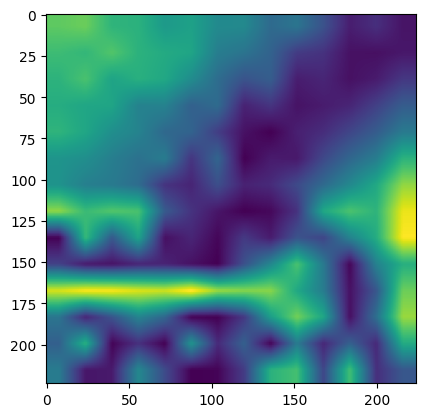

In [21]:
%matplotlib inline
plt.imshow(grayscale_cam[2])
plt.show()

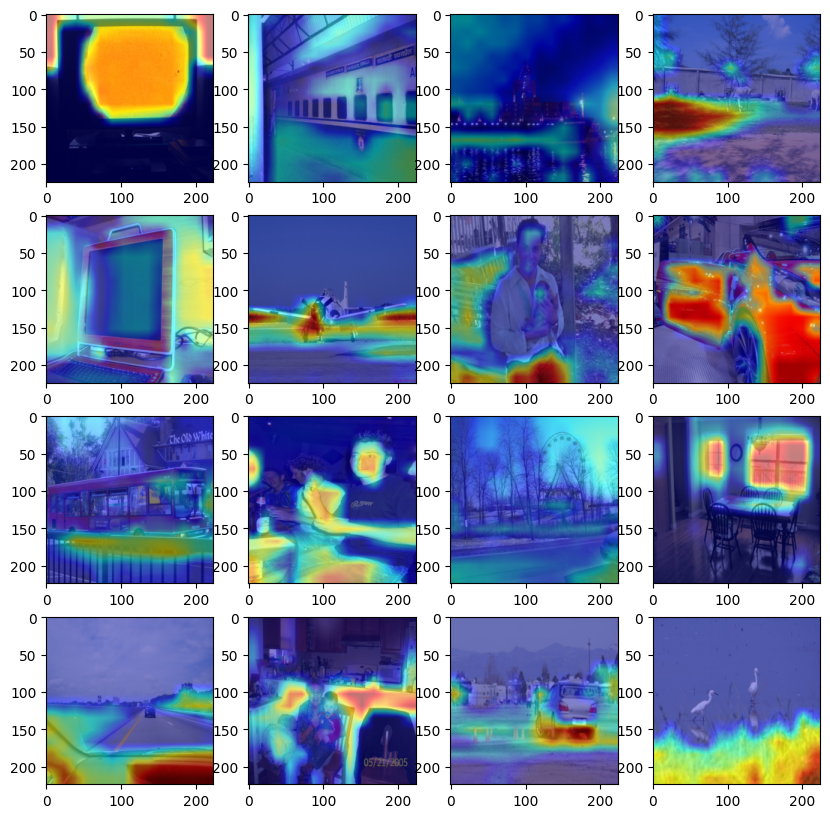

In [23]:
import cv2
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
img_list = []
plt.figure(figsize=(10, 10))
for i in range(args.batchsize):
    np_input = images[i].cpu().numpy()
    np_input = np.transpose(np_input, (1, 2, 0))
    np_input.shape
    grayscale_cam_ = grayscale_cam[i]
    cam_image = show_cam_on_image(np_input, grayscale_cam_, use_rgb=True)
    img_list.append(cam_image)
    plt.subplot(4, 4, i+1)
    # plt.imshow(grayscale_cam_)
    plt.imshow(cam_image)

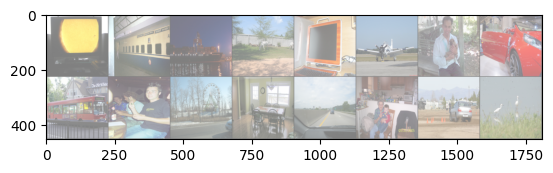

In [28]:
# show images and labels
imshow(torchvision.utils.make_grid(images))
# print labels

In [32]:
from torchvision import transforms as pth_transforms
# from visualize_attention import company_colors, apply_mask2
from PIL import Image, ImageDraw
from utils.visualize import * 
# read image 

def show_attn(net, img, index=None, nlayer=0):
    w_featmap = img.shape[-2] // 16
    h_featmap = img.shape[-1] // 16

    # attentions = vit.get_last_selfattention(img.cuda())
    # attentions = net.module.get_attention_maps(img.cuda())[-1]
    attentions = net.module.get_attention_maps(img.cuda())[nlayer]

    print('attentions shape', attentions.shape)
    print('attentions', attentions)
    nh = attentions.shape[1] # number of head
    print('number of head', nh)
    # we keep only the output patch attention
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

    # we keep only a certain percentage of the mass
    val, idx = torch.sort(attentions)
    val /= torch.sum(val, dim=1, keepdim=True)
    cumval = torch.cumsum(val, dim=1)
    th_attn = cumval > (1 - 0.6)
    idx2 = torch.argsort(idx)
    for head in range(nh):
        th_attn[head] = th_attn[head][idx2[head]]
    th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
    # interpolate
    th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=16, mode="nearest")[0].cpu().numpy()
    print('th_attn.shape: ', th_attn.shape)
    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=16, mode="nearest")[0].cpu().numpy()

    # save attentions heatmaps
    prefix = f'id{index}_' if index is not None else ''
    os.makedirs('pics/', exist_ok=True)
    torchvision.utils.save_image(torchvision.utils.make_grid(img, normalize=True, scale_each=True), os.path.join('pics/', "img" + ".png"))
    img = Image.open(os.path.join('pics/', "img" + ".png"))

    attns = Image.new('RGB', (attentions.shape[2] * nh, attentions.shape[1]))
    for j in range(nh):
        print('attentions[j].shape: ', attentions[j].shape)
        fname = os.path.join('pics/', "attn-head" + str(j) + ".png")
        plt.imsave(fname=fname, arr=attentions[j], format='png')
        attns.paste(Image.open(fname), (j * attentions.shape[2], 0))

    return attentions, th_attn, img, attns


# img = Image.open('../data/NIH/processed/images_001/images/00000001_000.png')
# img = img.resize((224, 224))
img = images.permute(0, 2, 3, 1)[2]
img = torch.tensor(np.array(img)).permute(2, 0, 1)
img.shape

transform = pth_transforms.Compose([
    pth_transforms.ToPILImage(),
    pth_transforms.Grayscale(num_output_channels=3),
    pth_transforms.Resize([224, 224]),
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

img = transform(img)
# make the image divisible by the patch size
w, h = img.shape[-2] - img.shape[-2] % 16, img.shape[-1] - img.shape[-1] % 16
print(w, h)
img = img[:, :w, :h].unsqueeze(0)
print(img.shape)
attentions, th_attn, pic_i, pic_attn = show_attn(net, img, nlayer=-1)
print("attentions.shape: ", attentions.shape)
print("th_attn.shape: ", th_attn.shape)
print("pic_i.shape: ", pic_i.size)
pic_attn_color = show_attn_color(img[0].permute(1, 2, 0).cpu().numpy(), attentions, th_attn, head=[0,1,2])
final_pic = Image.new('RGB', (pic_i.size[1] * 2 + pic_attn.size[0], pic_i.size[1]))
final_pic.paste(pic_i, (0, 0))
final_pic.paste(pic_attn_color, (pic_i.size[1], 0))
final_pic.paste(pic_attn, (pic_i.size[1] * 2, 0))
display(final_pic)

224 224
torch.Size([1, 3, 224, 224])
attentions shape torch.Size([1, 3, 197, 197])
attentions tensor([[[[0.0046, 0.0052, 0.0052,  ..., 0.0048, 0.0051, 0.0050],
          [0.0055, 0.0050, 0.0050,  ..., 0.0051, 0.0050, 0.0049],
          [0.0055, 0.0050, 0.0050,  ..., 0.0051, 0.0050, 0.0049],
          ...,
          [0.0058, 0.0050, 0.0050,  ..., 0.0053, 0.0050, 0.0050],
          [0.0054, 0.0050, 0.0050,  ..., 0.0051, 0.0050, 0.0049],
          [0.0052, 0.0050, 0.0050,  ..., 0.0050, 0.0051, 0.0049]],

         [[0.0050, 0.0051, 0.0051,  ..., 0.0051, 0.0051, 0.0050],
          [0.0053, 0.0050, 0.0050,  ..., 0.0054, 0.0051, 0.0051],
          [0.0053, 0.0050, 0.0050,  ..., 0.0054, 0.0051, 0.0051],
          ...,
          [0.0055, 0.0050, 0.0050,  ..., 0.0055, 0.0051, 0.0052],
          [0.0053, 0.0050, 0.0050,  ..., 0.0054, 0.0051, 0.0051],
          [0.0054, 0.0050, 0.0050,  ..., 0.0055, 0.0051, 0.0051]],

         [[0.0053, 0.0050, 0.0050,  ..., 0.0051, 0.0051, 0.0051],
          [0.0

RuntimeError: shape '[3, 224, 224]' is invalid for input of size 588

In [ ]:
len(net.module.get_attention_maps(img.cuda()))

In [ ]:
out = net(img.cuda())

In [ ]:
for i in range(12):
    attentions = net.module.get_attention_maps(img.cuda())[i]
    np_mean = np.mean(attentions.cpu().numpy())
    np_std = np.std(attentions.cpu().numpy())
    for j in range(attentions.shape[1]):
        np_mean = np.mean(attentions[:, j, :, :].cpu().numpy())
        np_std = np.std(attentions[:, j, :, :].cpu().numpy())
        print(f'layer {i} head {j} mean: {np_mean}, std: {np_std}')
    # print(f'layer {i} mean: {np_mean}, std: {np_std}')

In [ ]:
import cv2
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
img_list = []
plt.figure(figsize=(10, 10))
for i in range(args.batchsize):
    np_input = images[i].cpu().numpy()
    np_input = np.transpose(np_input, (1, 2, 0))
    np_input.shape
    grayscale_cam_ = grayscale_cam[i]
    cam_image = show_cam_on_image(np_input, grayscale_cam_, use_rgb=True)
    img_list.append(cam_image)
    plt.subplot(4, 4, i+1)
    plt.imshow(grayscale_cam_)
    plt.axis('off')
plt.show()
